### TODO: 
* group by time and process at once
* id every separate transport

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
df = pd.read_csv('data/transport_data.csv')
df.head()

,log,lat,request_ts,trans_ts,label
0,30.295780,59.932167,1511956827,1511956594,0
1,30.219528,59.954617,1511956827,1511956746,-
2,30.409101,59.931679,1511956827,1511956747,-
3,30.293602,59.938892,1511956827,1511956759,-
4,30.360102,59.931103,1511956827,1511956767,-


In [14]:
min_t = df['trans_ts'].min()

df['trans_ts'] = df['trans_ts'] - min_t
df['request_ts'] = df['request_ts'] - min_t

df['day'] = df['trans_ts'] // 86400

df['trans_ts'] = df['trans_ts'] % 86400
df['request_ts'] = df['request_ts'] % 86400
df.head()

,log,lat,request_ts,trans_ts,label,day
0,30.295780,59.932167,233,0,0,0
1,30.219528,59.954617,233,152,-,0
2,30.409101,59.931679,233,153,-,0
3,30.293602,59.938892,233,165,-,0
4,30.360102,59.931103,233,173,-,0


In [ ]:
df_d1 = df_train[df_train['day'] == 0]
t = df_d1['request_ts'].unique()
n = len(t)

from matplotlib import animation

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(xlim=(59.91, 59.98), ylim=(30.20, 30.50))
line, = ax.plot([], [], lw=2)
sp = plt.scatter([], [], alpha=0.1, c='blue')

def init():
    line.set_data([], [])
    return line,

def animate(i):
    df_t = df_d1[df_d1['request_ts'] == t[i]]
    sp = plt.scatter(df_t['lat'].values, df_t['log'].values, alpha=0.2, c=df_t['label'].values)
    return sp,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=n, interval=10, blit=False)

anim.save('map.mp4', fps=10, extra_args=['-vcodec', 'libx264'])
plt.show()

In [42]:
df_clean = df[df['label'] != '-']
df_clean.head()

,log,lat,request_ts,trans_ts,label,day
0,30.295780,59.932167,233,0,0,0
8,30.385973,59.944260,233,188,0,0
11,30.359190,59.931217,233,193,?,0
13,30.374880,59.938213,233,208,1,0
17,30.347544,59.932667,233,217,0,0


In [43]:
df_train = df_clean[df_clean['label'] != '?']
df_dev = df_clean[df_clean['label'] == '?']

df_train['label'] = pd.to_numeric(df_train['label'])
df_train.head()

/media/andre6o6/aux/anaconda3/envs/nn/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,log,lat,request_ts,trans_ts,label,day
0,30.295780,59.932167,233,0,0,0
8,30.385973,59.944260,233,188,0,0
13,30.374880,59.938213,233,208,1,0
17,30.347544,59.932667,233,217,0,0
23,30.312321,59.937405,233,226,2,0


/media/andre6o6/aux/anaconda3/envs/nn/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


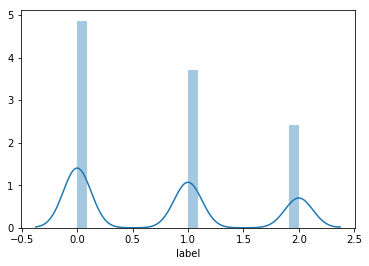

In [15]:
sns.distplot(df_train['label'])

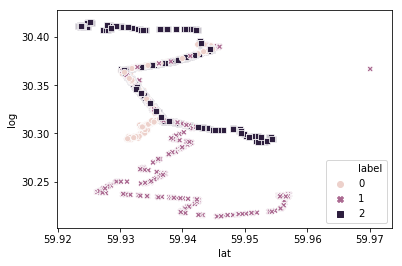

In [47]:
sns.scatterplot(x='lat', y='log', data=df_train, hue="label", style="label")

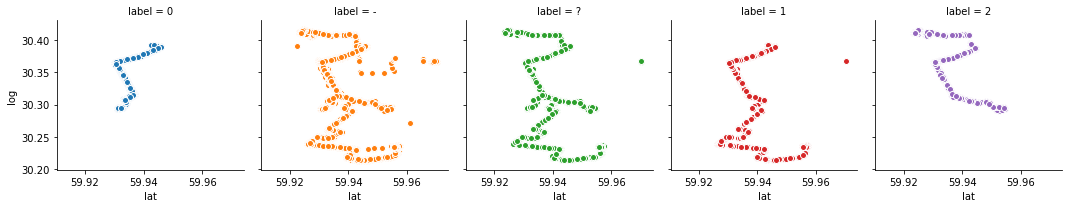

In [50]:
g = sns.FacetGrid(df, col="label", hue="label")
g = (g.map(plt.scatter, "lat", "log", edgecolor="w"))

In [64]:
import datetime
print(datetime.datetime.fromtimestamp(df["trans_ts"].min()))
print(datetime.datetime.fromtimestamp(df["trans_ts"].max()))

2017-11-29 14:56:34
2017-12-03 14:59:49


In [136]:
df_cycle = df.copy()
df_cycle['trans_ts'] = df_cycle['trans_ts']%86400
df_cycle['request_ts'] = df_cycle['request_ts']%86400

print(datetime.datetime.fromtimestamp(df_cycle["trans_ts"].min()))
print(datetime.datetime.fromtimestamp(df_cycle["trans_ts"].max()))

df_clean_cycle = df_cycle[df_cycle['label'] != '-']
df_train_cycle = df_clean_cycle[df_clean_cycle['label'] != '?']

df_train_cycle['label'] = pd.to_numeric(df_train_cycle['label'])

1970-01-01 05:59:39
1970-01-02 00:59:39


/media/andre6o6/aux/anaconda3/envs/nn/lib/python3.5/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [371]:
from sklearn.model_selection import train_test_split

list_labels = df_train["label"].values
values = df_train.drop(columns="label").values

X_train, X_test, y_train, y_test = train_test_split(values, list_labels, test_size=0.2, random_state=40)

print(X_train.shape, X_test.shape)
print(len(y_train), len(y_test))

(8000, 4) (2000, 4)
8000 2000


In [372]:
X_mean, X_std = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - X_mean)/X_std
X_test = (X_test - X_mean)/X_std

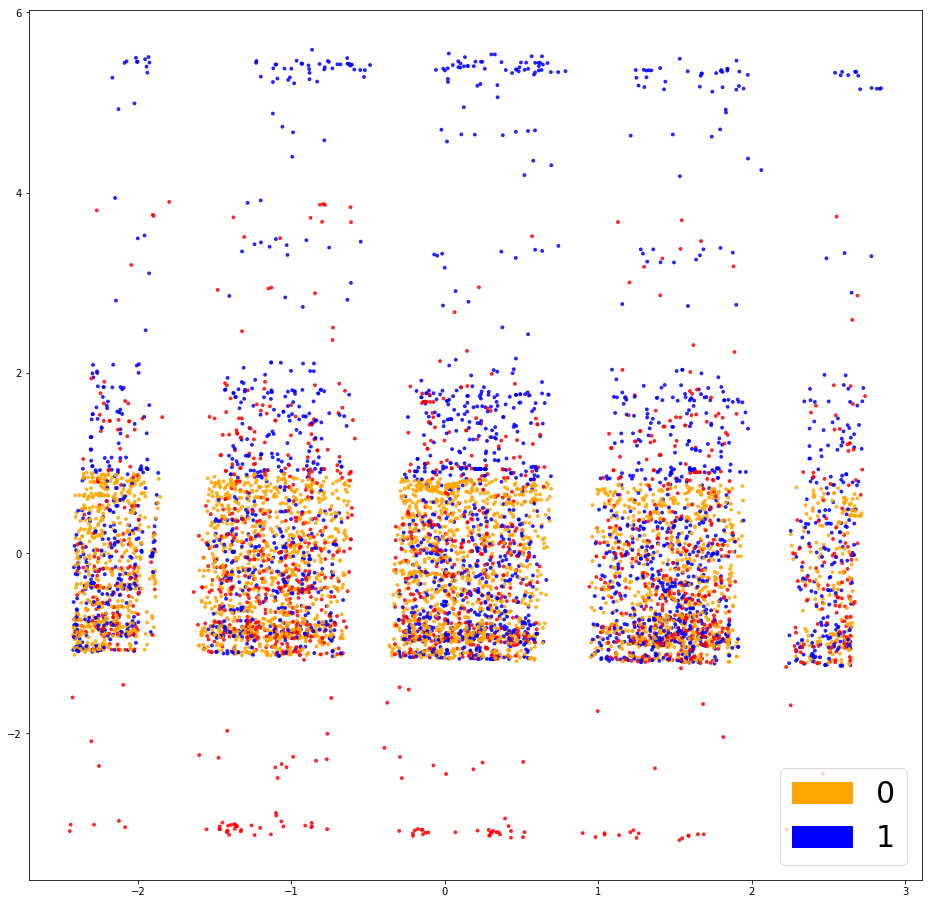

In [373]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','red']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='0')
            green_patch = mpatches.Patch(color='blue', label='1')
            teal_patch = mpatches.Patch(color='teal', label='2')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train, y_train)
plt.show()

In [374]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [375]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.388, precision = 0.405, recall = 0.388, f1 = 0.393


In [376]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors = 1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.536, precision = 0.533, recall = 0.536, f1 = 0.534


In [377]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.592, precision = 0.590, recall = 0.592, f1 = 0.580


In [378]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.549, precision = 0.548, recall = 0.549, f1 = 0.548


In [379]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=100, learning_rate=1.0, random_state=40)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.545, precision = 0.641, recall = 0.545, f1 = 0.476


In [380]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=40)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.579, precision = 0.581, recall = 0.579, f1 = 0.559


In [384]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(64, 64, 16), max_iter=1000, random_state=40)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.552, precision = 0.658, recall = 0.552, f1 = 0.490


In [130]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

In [470]:
#from sklearn.preprocessing import LabelBinarizer
#enc = LabelBinarizer().fit(y_train)
#y_train_oh = enc.transform(y_train)
#y_test_oh = enc.transform(y_test)

train_x = torch.from_numpy(np.array(X_train, dtype='float32'))
train_y = torch.from_numpy(np.array(y_train, dtype='float32'))
test_x = torch.from_numpy(np.array(X_test, dtype='float32'))
test_y = torch.from_numpy(np.array(y_test, dtype='float32'))

trainset = TensorDataset(train_x, train_y)
testset = TensorDataset(test_x, test_y)

trainloader = DataLoader(trainset, batch_size=10, shuffle=True)
testloader = DataLoader(testset, batch_size=10, shuffle=False)

In [457]:
class Net(nn.Module):
    def __init__(self, n_features=4, n_classes=3):
        super(Net, self).__init__()
        
        self.relu = nn.ReLU()
        self.softmax = torch.nn.LogSoftmax(dim=1)
        
        self.fc1 = nn.Linear(n_features, 256)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(16)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(8)
        self.fc4 = nn.Linear(64, n_classes)
        
    def forward(self, x):
        
        x = self.fc1(x)
        #x = self.bn1(x)
        x = self.relu(x)
        
        x = self.fc2(x)
        #x = self.bn2(x)
        x = self.relu(x)
        
        x = self.fc3(x)
        #x = self.bn3(x)
        x = self.relu(x)
        
        x = self.fc4(x)
        #x = self.softmax(x)
        return x

In [458]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

net = Net().to(device)

In [462]:
lr = 1e-5    # -3 --> -5

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10)

In [429]:
def train(verbose=True):
    net.train()
    running_loss = 0.0
    train_loss = 0.0
    for i, (sample, label) in enumerate(trainloader):
        optimizer.zero_grad()
        
        sample, label = sample.to(device), label.to(device)
        output = net(sample)
        loss = criterion(output, label.long())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_loss += loss.item()
        
        if i % 100 == 99:
            #print(' [{} - {}],\ttrain loss: {:.5}'.format(epoch+1, i+1, running_loss/100))
            running_loss = 0.0
    train_loss /= i
    print('[{}], \ttrain loss: {:.5}'.format(epoch+1, train_loss))
    return train_loss

def validate():
    net.eval()
    val_loss = 0.0
    for i, (sample, label) in enumerate(testloader):
        sample, label = sample.to(device), label.to(device)
        with torch.no_grad():
            output = net(sample)
        val_loss += sum(output.argmax(dim=1) == label.long()).item()     #accuracy
    val_loss /= len(testset)
    print(' [{}], \tval loss: {:.5}'.format(epoch+1, val_loss))
    return val_loss

In [471]:
num_epoch = 10
#history = []

for epoch in range(num_epoch):
    train_loss = train()
    val_loss = validate()
    history.append((train_loss, val_loss))
    #scheduler.step(train_loss)

[1], 	train loss: 0.84577
 [1], 	val loss: 0.547
[2], 	train loss: 0.84552
 [2], 	val loss: 0.55
[3], 	train loss: 0.8456
 [3], 	val loss: 0.551
[4], 	train loss: 0.84532
 [4], 	val loss: 0.548
[5], 	train loss: 0.8451
 [5], 	val loss: 0.5465
[6], 	train loss: 0.84531
 [6], 	val loss: 0.546
[7], 	train loss: 0.84514
 [7], 	val loss: 0.5455
[8], 	train loss: 0.84541
 [8], 	val loss: 0.5495
[9], 	train loss: 0.84477
 [9], 	val loss: 0.544
[10], 	train loss: 0.84575
 [10], 	val loss: 0.548


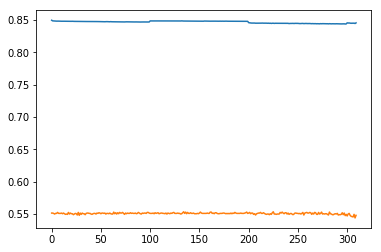

In [472]:
plt.plot(history)

In [ ]:
# 32-16-8 [10] cyclic : 0.861 | 0.553
#                 reg : 0.849 | 0.553

#         [20]        : 0.847 | 0.548
#         [20]    +bn : 0.91  | 0.54

# 64-32-16[10]        : 0.85  | 0.55
#         [20]        : 0.857 | 0.554

# 256-128-64          : 0.847 | 0.551